# Baseline simulation
This is a Jupyter notebook execution of the default performance test simulation.

In [1]:
from COVID19.model import Model, Parameters
import COVID19.simulation as simulation

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
params.set_param( "n_total", 10000)

model = simulation.COVID19IBM(model = Model(params))

In [2]:
sim   = simulation.Simulation(env = model, end_time = 200 )
sim.steps( 200 )

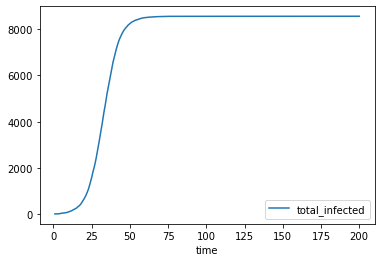

In [3]:
import pandas as pd
timeseries = pd.DataFrame( sim.results )
timeseries.plot( x = "time", y = "total_infected" )

## Extract network settings
We want to see how the probability of a person in each network becoming infected changes over time. Let us calculate the mean and variance for this probability for each network over the number of days in the simulation.

By default the model calculates the infectiousness hazard rate (the probability you will be infected by this interaction with this ill individual) from the network's combined transmission multiplier multiplied by the infector's infectiousness multiplier multipled by the strains infectiousness multiplied by the infectiousness for this strain on this day of infectiousness (i.e. the specific part of the infectiousness curve at this point in time). This is the interaction hazard value. See ../src/disease.c:111 transmit_virus_by_type() for details.

The strain infectious curve is a gamma_rate_curve distribution. See ../src/strain.c:42 initialise_infectious_curves(). This is static for a given day of being infectious as it's the same throughout the simulation for this strain.

The network transmission multiplier comes from a parameter for the simulation and is static throughout the simulation by the type of network. In the baseline parameters, for example, it is X for a household network, Y for a random network, and Z for a work network. See baseline_parameters.csv relative_transmission_household, relative_transmission_occupation, and relative_transmission_random parameters

The initial individual hazard probability is taken from the exponential distribution and is static for each individual throughout the whole simulation. This is divided by the adjusted susceptibility for that person's age group when setting up the simulation.

If the individual's static hazard value is less than this network interactions hazard value, then the individual is deemed to now be infected. See the new_infection() call in ../src/disease.c:174 transmit_virus_by_type() function.

All interactions throughout all networks of the same type thus have a static infectiousness multiplier which is only changed by the infectiousness of an individual in that network based on the number of days that individual has been infectious. Removing this from consideration, our network transmission multiplier values should be:-

Network | Mean Infectiousness | Variance of infectiousness
---|---|---
Work | 1 | 0
Home | 2 | 0
Random | 1 | 0

Let us try to calculate this from the model itself... (we'll calculate it over time even though we know its static so the code remains the same for future changes).


### Calculate mean and variance of infectiousness of all interactions across all networks of the same type
We expect to see the above table reproduced.
There will be no change to the number of infected.

In [4]:
import numpy as np
import math

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
n_total = 10000
params.set_param( "n_total", n_total)

pyModel = Model(params)
model = simulation.COVID19IBM(model = pyModel)

sim   = simulation.Simulation(env = model, end_time = 200 )

# underlyingModel = sim.env.model

# valuesWork = []
# valuesHome = []
# valuesRandom = []

# infectiousPerDay = []
# susceptiblesPerDay = []
# immunePerDay = []
# dailyRecovered = []
# hostsPerDay = []
# r0PerDay = []
# r0FixedPerDay = []
# rInstPerDay = []
# gPerDay = []
# gTenPerDay = []
# gFivePerDay = []
# gCont = []
# tauPerDay = []
# lastImmune = 0

# # From the Individual based Perspectives on R0 paper:-
# dmpPerDay = [] # Shared amongst both models
# sigmaMiPerDay = [] # Binomial individual model
# sigmaMptauPerDay = [] # Fixed model


# dayInfected = []
# for a in range(n_total):
#     dayInfected[a] = -1

import pycontactgraph.analysis as analysis

# def dayStartCallbackBasic(underlyingModel):
#     # Modify network probabilities each step
#     for networkId in range(underlyingModel.c_model.n_networks):
#         network = underlyingModel.get_network_by_id(networkId)
        
#         if network.type() == 0:
#             valuesHome.append(network.transmission_multiplier_combined())
#         elif network.type() == 1:
#             valuesWork.append(network.transmission_multiplier_combined())
#         elif network.type() == 2:
#             valuesRandom.append(network.transmission_multiplier_combined())
#         # See constant.h:155 INTERACTION_TYPE enum for other types (hospital networks)

analyserBasic = analysis.SimulationAnalyser(sim)
analyserBasic.simulateAndAnalyse()
        
# for b in range(1,201):
#     # Modify network probabilities each step
#     for networkId in range(underlyingModel.c_model.n_networks):
#         network = underlyingModel.get_network_by_id(networkId)
        
#         if network.type() == 0:
#             valuesHome.append(network.transmission_multiplier_combined())
#         elif network.type() == 1:
#             valuesWork.append(network.transmission_multiplier_combined())
#         elif network.type() == 2:
#             valuesRandom.append(network.transmission_multiplier_combined())
#         # See constant.h:155 INTERACTION_TYPE enum for other types (hospital networks)
    
#     # Calculate R0 estimate - R = 1/ x* = 1 / (X / N) = N / X (equilibrium),
#     # where N is total number of hosts, X is susceptible hosts
#     # from Anderson & May Chapter 4 page 69 (The basic model: statics)
#     xBar = 0
#     nBar = 0
#     immuneBar = 0
#     infectious = 0
#     dmp = 0
#     # TODO should this be AFTER sim step???
#     indivs = underlyingModel.get_individuals()
#     for indivId in range(n_total):
#         indivStatus = indivs.current_status[indivId]
#         if indivStatus == 0:
#             # Susceptible
#             xBar += 1
#             nBar += 1
            
#         # 10=Death - not allowed for in Anderson & May, so discount
#         # 21=Mortuary - again not allowed for
#         # 9=Recovered (and immune by default in our sim run), so discount? (NO!)
#         elif indivStatus == 9:
#             #nBar += 1
#             immuneBar += 1
#         elif (indivStatus != 10) and (indivStatus != 21): # and (indivStatus != 9):
#             # Infected or infectious #(or recovering)
#             nBar += 1
# #             if (dayInfected[indivId] == -1):
# #                 dayInfected[indivId] = b
        
#         # Asymptomatic, symptomatic, symptomatic_mild
#         if (indivStatus == 3) or (indivStatus == 4) or (indivStatus == 5):
#             infectious += 1
    
#     if b > 1:
#         susceptiblesPerDay.append(xBar)
#         hostsPerDay.append(nBar)
#         immunePerDay.append(immuneBar)
#         infectiousPerDay.append(infectious)
#         if xBar != 0:
#             r0PerDay.append(nBar / xBar)
#         else:
#             r0PerDay.append(0)
            
#         # Calculate NEWLY recovered per day
#         if b > 2:
#             dailyRecovered.append(immuneBar - lastImmune)
#         else:
#             dailyRecovered.append(immuneBar)
        
#         if infectious > 0:
#             gPerDay.append(dailyRecovered[b - 2] / infectious)
#         else:
#             gPerDay.append(0)
            
#         # Estimate G based on total recovered over total infectious cases
#         if (b > 2):
#             totalR = 0
#             totalI = 0
#             for idx in range(0,b - 2):
#                 totalR += dailyRecovered[idx]
#                 totalI += infectiousPerDay[idx]
#             if (totalI > 0):
#                 g = totalR / totalI
#                 gCont.append(g)
                
#                 # We can calculate Tau per day now
#                 r0 = 0
#                 denom = xBar
#                 if (xBar > 0):
#                     r0 = (nBar / xBar)
#                     denom = xBar - r0
#                 if (denom > 0):
#                     num = r0 * g
#                     # Multiplying by n_total so we have it as a proportion of total population
#                     tau = num / denom
#                     tauPerDay.append(n_total * tau)
#                     # We can now reestimate r0
#                     if (g > 0):
#                         r0FixedPerDay.append(xBar * (1 - math.exp(-tau / g)))
#                     else:
#                         r0FixedPerDay.append(0)
#                 else:
#                     tauPerDay.append(0)
#                     r0FixedPerDay.append(0)
#             else:
#                 gCont.append(0)
#                 tauPerDay.append(0)
#                 r0FixedPerDay.append(0)
#         else:
#             gCont.append(0)
#             tauPerDay.append(0)
#             r0FixedPerDay.append(0)
            
#         # Estimate G based on last 10 days worth of data
#         if b > 12:
#             recLastTen = 0
#             infectiousLastTen = 0
#             for idx in range(b - 12,b - 2):
#                 recLastTen += dailyRecovered[idx]
#                 infectiousLastTen += infectiousPerDay[idx]
#             if infectiousLastTen > 0:
#                 gTenPerDay.append(recLastTen / infectiousLastTen)
#             else:
#                 gTenPerDay.append(0)
#         else:
#             gTenPerDay.append(0)
#         # Estimate G based on last 5 days worth of data
#         if b > 7:
#             recLast = 0
#             infectiousLast = 0
#             for idx in range(b - 7,b - 2):
#                 recLast += dailyRecovered[idx]
#                 infectiousLast += infectiousPerDay[idx]
#             if infectiousLast > 0:
#                 gFivePerDay.append(recLast / infectiousLast)
#             else:
#                 gFivePerDay.append(0)
#         else:
#             gFivePerDay.append(0)
            
            
#         lastImmune = immuneBar
    

#     # Run sim
#     sim.steps(1)
    
    # Now calculate R0(Rt) using the Individual Perspectives on R0 paper's Appendix A formula
    # 1. If person is infectious, list all of their susceptible contacts
    # 2. Compare to this the the contacts that they infect (transmissions)
    # 3. The proportion for a time p (Which we'll set at 1 day, rather than number of minutes, for now) is the Rt
    # 4. Add this number to the total d(m,p) sum for this day
    # Assumption: Person is infectious once per simulation (i.e. an immunising infection)
    
#     for indivId in range(n_total):
#         infectorId = indivs.ID[indivId]
#         indivStatus = indivs.current_status[indivId]
#         if (indivStatus == 3) or (indivStatus == 4) or (indivStatus == 5):
#             # Infectious
#             # Get all interactions on this day
#             # CANNOT DO THIS IN PYTHON - NEEDS TO BE IN C!!!
#             n_interactions = underlyingModel.c_model.population[infectorId].n_interactions[b]
#             if (n_interactions > 0):
#                 interactions = underlyingModel.c_model.population[infectorId].interactions[b]
#                 for intIdx in range(0,n_interactions):
#                     interaction = interactions[intIdx]
#                     if interaction.individual.status == 0: # susceptible
#                         # log contact event
#                         contactEvents.append(ContactEvent(
#                             infectorId,
#                             interaction.individual.idx,
#                             b
#                         ))
            

# # All contact events - whether infected or not - but ONLY when infector IS infectious
# contactEvents = underlyingModel.get_contact_events()

# # The simulation.py file saves summary calculations for each day in arrays (one item per day)
# rInstPerDay = sim.results["R_inst"][-199:] # Last 199 elements




# There are also R_inst_05 and R_inst_95 for the 5 and 95 percentiles

# Now look at all interactions across all networks, and calculate total interactions per person-per network-per day
# Per day, for each infectious individual in a network, what are their susceptible interactions
# ... and what of these resulted in infections?
# ... use this to calculate R0 based on Keeling and Grenfell, Appendix A

# For each person
# Find when they were infected and recovered
# For days they were infectious, determine all contact events per network, and number that resulted in infection

# totalContacts = [][] # day vs. individual_id => total contacts (in all states, to all states)
# susceptibleContacts = [][] # day vs. individual_id => number of susceptible contacts (no matter my state)
# infectionsCaused = [][] # day vs. individual_id => number of infections I've caused on this day whilst infectious
# emptyIndivs = []
# for indiv_id in range(n_total):
#     emptyIndivs.append(0)
# for day in range(1,201):
#     totalContacts[day] = emptyIndivs
#     susceptibleContacts[day] = emptyIndivs
#     infectionsCaused[day] = emptyIndivs
    
# Now loop through all interactions and infections, and update the totals as necessary
# indivs = underlyingModel.get_individuals()

# def findContactEvent(day,infectorId,contactId):
#     for idx in len(contactEvents):
#         if contactEvents[idx].matches(day,infectorId,contactId):
#             return contactEvents[idx]
#     return null

# - Infections
# infectorIds = set()
# trans = underlyingModel.get_transmissions()
# for tid in trans.index:
# #     infectionsCaused[tx["time_infected"][tid]][tx["ID_source"][tid]] += 1
#     infectorIds.add(trans["ID_source"][tid])
#     ce = findContactEvent(
#         tx["time_infected"][tid],
#         tx["ID_source"][tid],
#         tx["ID_recipient"][tid]
#     )
#     if null == ce:
#         # Shouldn't happen!
#         print("Got a null contact event on day " + str(tx["time_infected"][tid]) + " for infector " + str(tx["ID_source"][tid]) + " to recipient " + str(tx["ID_recipient"][tid]))
#     else:
#         # Mark CE as wasInfected = true
#         ce.wasInfected = True
    
# - Interactions - from contact events list
# for day in range(1,201):
# for indiv_id in range(n_total):
#     interactionsCount = indivs[indiv_id].n_interactions[day]
#     totalContacts[day][indiv_id] += interactionCount


WE HAVE FOUND 569486 contact events


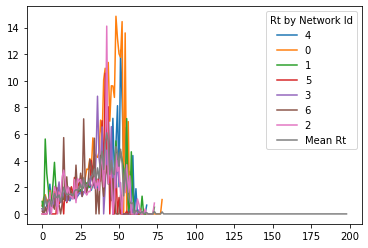

r0PerDay length: 199
r0FixedPerDay length: 199
rInstPerDay length: 199


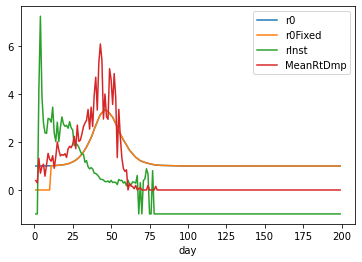

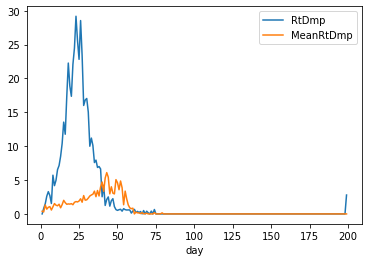

In [12]:

# Now calculate R0(Rt) using the Individual Perspectives on R0 paper's Appendix A formula
# 1. If person is infectious, list all of their susceptible contacts
# 2. Compare to this the the contacts that they infect (transmissions)
# 3. The proportion for a time p (Which we'll set at 1 day, rather than number of minutes, for now) is the Rt
# 4. Add this number to the total d(m,p) sum for this day
# Assumption: Person is infectious once per simulation (i.e. an immunising infection)   

# print("WE HAVE FOUND " + str(len(contactEvents)) + " contact events")
# for ce in contactEvents:
#     print(" day " + str(ce.getDay()) + " infector: " + str(ce.getInfectorId()) + " contact: " + str(ce.getContactId()) 
#           + " networkId: " + str(ce.getNetworkId()) + " infection caused?: " + 
#           ("yes" if ce.wasInfectionCaused() else "no"))

# Loop through all contact events by day and determine infection proportions per infector
# infectorsPerDay = []
# meanDmpPerDay = []
# for b in range(2,201):
#     dmp = 0
#     infectors = 0
#     for infectorId in infectorIds:
#         infectorContactsUninfected = 0
#         infectorContactsInfected = 0
#         for ce in contactEvents:
#             if ce.matchesInfector(b,infectorId):
#                 if ce.wasInfectionCaused():
#                     infectorContactsInfected += 1
#                 else:
#                     infectorContactsUninfected += 1
#         # If either if non zero, we can calculate d(m,p) for this contact on this day, and add to total
#         total = infectorContactsUninfected + infectorContactsInfected
#         if total > 0:
#             dmp += infectorContactsInfected / total
#             infectors += 1
    
#     dmpPerDay.append(dmp)
#     infectorsPerDay.append(infectors)
#     if infectors > 0:
#         meanDmpPerDay.append(dmp / infectors)
#     else:
#         meanDmpPerDay.append(0)

# infPerDay = []
# susPerDay = []
# for b in range(2,201):
#     infPerDay.append(0)
#     susPerDay.append(0)

# Collect results
finalTau = analyserBasic.getFinalTau()

# This is optional (compute and memory intensive), so we call it explicitly
analyserBasic.analyseContactEvents()
contactEvents = analyserBasic.getContactEvents() # Only available after running the above


# # TODO once happy with the below classes, move them into COVID19/analyser.py
# class InfectorSummaryNetwork:
#     susceptibles = set()
#     infected = set()
        
#     def addInfection(self,ce):
#         self.susceptibles.add(ce.getContactId())
#         if ce.wasInfectionCaused():
#             self.infected.add(ce.getContactId())
            
#     def getSusceptibleCount(self):
#         return len(self.susceptibles)
    
#     def getInfectedCount(self):
#         return len(self.infected)
    

# class InfectorSummary:
#     networkSummaries = {} # networkIdStr -> InfectorSummaryNetwork

#     def addInfection(self,ce):
#         networkIdStr = str(ce.getNetworkId())
#         if not networkIdStr in self.networkSummaries:
#             self.networkSummaries[networkIdStr] = InfectorSummaryNetwork()
#         self.networkSummaries[networkIdStr].addInfection(ce)
            
#     def getAllSusceptibleCount(self):
#         susCount = 0
#         for networkIdStr in self.networkSummaries:
#             susCount += self.networkSummaries[networkIdStr].getSusceptibleCount()
#         return susCount
    
#     def getAllInfectedCount(self):
#         infCount = 0
#         for networkIdStr in self.networkSummaries:
#             infCount += self.networkSummaries[networkIdStr].getInfectedCount()
#         return infCount
    
#     def getSusceptibleCount(self,networkIdStr):
#         if networkIdStr in self.networkSummaries:
#             return self.networkSummaries[networkIdStr].getSusceptibleCount()
#         else:
#             return 0
    
#     def getInfectedCount(self,networkIdStr):
#         if networkIdStr in self.networkSummaries:
#             return self.networkSummaries[networkIdStr].getInfectedCount()
#         else:
#             return 0
        
#     def getNetworkIds(self):
#         networkIds = set()
#         for networkIdStr in self.networkSummaries:
#             networkIds.add(networkIdStr)
#         return networkIds
    
# # finalTau = tauPerDay[len(tauPerDay)-1]
# class InfectorList:
#     infectors = {} # Dictionary using str(infectorId) -> InfectorSummary()
    
# #     def _init_(self):
# #         # Nothing

#     def addInfector(self,ce):
#         # Check if index exists
#         infId = str(ce.getInfectorId())
#         # If it doesn't, create it
#         if not infId in self.infectors:
#             self.infectors[infId] = InfectorSummary()
#         # Add infection record as required
#         self.infectors[infId].addInfection(ce)
        
#     def calcRtAllNetworks(self):
#         # Determine infector set for each number of susceptibles
#         infectorsBySusceptibleTotal = {}
#         infectorCount = 0
#         for infectorIdStr in self.infectors:
#             # TODO check if it exists, and if not create a new set for Ids under the susceptibleCount in this dict
#             susCountStr = str(self.infectors[infectorIdStr].getAllSusceptibleCount())
#             if not susCountStr in infectorsBySusceptibleTotal:
#                 infectorsBySusceptibleTotal[susCountStr] = set()
#             infectorsBySusceptibleTotal[susCountStr].add(infectorIdStr)
#             if self.infectors[infectorIdStr].getAllInfectedCount() > 0:
#                 infectorCount += 1
#         # Calculate Rt for each d(m,p) we have in infectorsBySusceptibleTotal
#         rt = 0.0
#         for countStr in infectorsBySusceptibleTotal:
#             count = int(countStr) # This is 'm' from the paper
#             if len(self.infectors) != 0: # Shouldn't be possible... but...
#                 infCount = len(infectorsBySusceptibleTotal[countStr])
# #                 prop = infCount / len(self.infectors)
# #                 prop = infCount / (len(self.infectors) * totalPopulation)
#                 prop = infCount / infectorCount # Number who passed on at least one infection per day over those infectors total who had contact with susceptibles on the same day
#                 # Now calculate associated probability
#                 prob = count * (1.0 - math.exp(-finalTau)) / 10000.0 # Should this be total population or just susceptibles?
#                 rt += prop * prob
#         return rt
    
#     def calcRtByNetwork(self):
#         summaries = {} # networkIdStr -> {'infected': 0, 'suscep': 0}
#         results = {}
#         for infectorIdStr in self.infectors:
#             infector = self.infectors[infectorIdStr]
#             for networkIdStr in infector.getNetworkIds():
#                 if not networkIdStr in summaries:
#                     summaries[networkIdStr] = {'infected':0, 'susceptibles':0, 'allInfectors': set(), 'successfulInfectors': set()}
#                 if not networkIdStr in results:
#                     results[networkIdStr] = 0 # Rt initialisation for next loop
#                 newInfections = infector.getInfectedCount(networkIdStr)
#                 summaries[networkIdStr]["allInfectors"].add(infectorIdStr)
#                 if (newInfections > 0):
#                     summaries[networkIdStr]["successfulInfectors"].add(infectorIdStr)
#                 summaries[networkIdStr]["infected"] += newInfections
#                 summaries[networkIdStr]["susceptibles"] += infector.getSusceptibleCount(networkIdStr)
        
#         # Perform same as calcRtAllNetworks but do so by networkId
#         for networkIdStr in summaries:
#             infected = summaries[networkIdStr]["infected"]
#             sus = summaries[networkIdStr]["susceptibles"]
#             infectorCount = len(summaries[networkIdStr]["allInfectors"])
#             infCount = len(summaries[networkIdStr]["successfulInfectors"])
            
#             # Now its the same calculation as before
#             prop = infCount / infectorCount # Number who passed on at least one infection per day over those infectors total who had contact with susceptibles on the same day
#             # Now calculate associated probability
#             prob = sus * (1.0 - math.exp(-finalTau)) / 10000.0 # Should this be total population or just susceptibles?
#             results[networkIdStr] += prop * prob
            
#         return results
    
#     def infectorCount(self):
# #         return len(self.infectors)
#         infectorCount = 0
#         for infectorIdStr in self.infectors:
#             if self.infectors[infectorIdStr].getAllInfectedCount() > 0:
#                 infectorCount += 1
#         return infectorCount
    
#     def susceptibleCount(self):
#         susCount = 0
#         for infectorIdStr in self.infectors:
#             if self.infectors[infectorIdStr].getAllSusceptibleCount() > 0:
#                 susCount += 1
#         return susCount
    
# class InfectorSummariser:
#     infectorDays = [] # An array by Day index (0 to days-1)
    
#     def __init__(self, totalDays):
#         for idx in range(0, totalDays):
#             self.infectorDays.append(InfectorList())
            
#     def addRecord(self,ce):
#         infectorList = self.infectorDays[ce.getDay()-2]
#         infectorList.addInfector(ce)
        
#     def getRtCalculationAllNetworks(self):
#         rts = []
#         dayIdx = 0
#         for day in self.infectorDays:
#             rts.append(day.calcRtAllNetworks())
#             dayIdx += 1
#         return rts
    
#     def getRtCalculationByNetwork(self):
#         rts = []
#         for day in self.infectorDays:
#             rts.append(day.calcRtByNetwork())
#         return rts
    
#     def countOnDay(self,day):
#         return self.infectorDays[day].infectorCount()
    
#     def susOnDay(self,day):
#         return self.infectorDays[day].susceptibleCount()
        
# summariser = InfectorSummariser(199)
# for ce in contactEvents:
#     summariser.addRecord(ce)
    
# meanDmpPerDay = summariser.getRtCalculationAllNetworks()

# print("Infector count on day 10: " + str(summariser.countOnDay(10)) + " and sus: " + str(summariser.susOnDay(10)))
# print("Infector count on day 30: " + str(summariser.countOnDay(30)) + " and sus: " + str(summariser.susOnDay(30)))
# print("Infector count on day 50: " + str(summariser.countOnDay(50)) + " and sus: " + str(summariser.susOnDay(50)))
# print("Infector count on day 100: " + str(summariser.countOnDay(100)) + " and sus: " + str(summariser.susOnDay(100)))

# def printCE(ce):
#     print("Day: " + str(ce.getDay()) + " networkId: " + str(ce.getNetworkId()) + " infectorId: " + str(ce.getInfectorId()) + " contactId: " + str(ce.getContactId()) + " wasInfected?: " + str(ce.wasInfectionCaused()))

# printCE(contactEvents[0])
# printCE(contactEvents[50])
# printCE(contactEvents[500])
# printCE(contactEvents[1000])
# printCE(contactEvents[2000])
# printCE(contactEvents[3000])
# printCE(contactEvents[4000])
# printCE(contactEvents[5000])
# printCE(contactEvents[20000])
# printCE(contactEvents[50000])

# # currently day,network
# networkMeanDmpPerDaySource = summariser.getRtCalculationByNetwork()


# Now denormalise the data into three columns
# networkMeanDmpPerDayNetwork = []
# networkMeanDmpPerDayValue = []
# networkMeanDmpPerDayDay = []
# dayIndex = 1
# for dayData in networkMeanDmpPerDaySource:
#     dayIndex += 1
#     for networkIdStr in dayData:
#         networkMeanDmpPerDayNetwork.append(networkIdStr)
#         networkMeanDmpPerDayValue.append(dayData[networkIdStr])
#         networkMeanDmpPerDayDay.append(dayIndex)
        
# print("Network ID: " + networkMeanDmpPerDayNetwork[100])
# print("Network ID: " + networkMeanDmpPerDayNetwork[250])
# print("Network ID: " + networkMeanDmpPerDayNetwork[500])
# print("Network ID: " + networkMeanDmpPerDayNetwork[750])
# print("Network ID: " + networkMeanDmpPerDayNetwork[1000])

# networkDayDmp = {} # networkIdStr -> [day] -> Rt

# dayIndex = 0
# for dayData in networkMeanDmpPerDaySource:
#     dayIndex += 1
#     for networkIdStr in dayData:
#         if not networkIdStr in networkDayDmp:
#             networkDayDmp[networkIdStr] = []
#         networkDayDmp[networkIdStr].append(dayData[networkIdStr])

    
#     susPerDay[ce.getDay()-2] += 1
#     if ce.wasInfectionCaused():
#         infPerDay[ce.getDay()-2] += 1

    
# print("50th day data: infections: " + str(infPerDay[49]) + ", susceptibles: " + str(susPerDay[49]))
    
    
# for b in range(0,199):
#     # If either if non zero, we can calculate d(m,p) for this contact on this day, and add to total
#     total = susPerDay[b]
#     infectors = infPerDay[b]
#     if total > 0:
#         meanDmpPerDay.append(infectors / total)
#     else:
#         meanDmpPerDay.append(0)
        
        

# Now calculate Mean and Variance over r0, for days when we have valid susceptibles
# validDays = 0
# totalR0s = 0
# maxR0 = 0
# for d in range(0,199):
#     if susceptiblesPerDay[d] != 0:
#         validDays += 1
#         totalR0s += r0PerDay[d]
#         if r0PerDay[d] > maxR0:
#             maxR0 = r0PerDay[d]
        
# # Calculate mean
# meanR0 = 0
# if validDays > 0:
#     meanR0 = totalR0s / validDays
# # Calculate variance
# totalR0Deviations = 0
# varianceR0 = 0
# if meanR0 > 0 and validDays > 1: # Sample variance, so need at least 2 days worth of data
#     for d in range(0,199):
#         if susceptiblesPerDay[d] != 0:
#             totalR0Deviations += pow(r0PerDay[d] - meanR0,2)
#     varianceR0 = totalR0Deviations / (validDays - 1)
        
    
timeseriesBaseline = pd.DataFrame( sim.results )
#timeseriesBaseline.plot( x = "time", y = "total_infected" )


# rtDmpByNetwork = pd.DataFrame({'day': networkMeanDmpPerDayDay,  'Rt': networkMeanDmpPerDayValue}, index= networkMeanDmpPerDayNetwork)
# rtDmpByNetwork.plot(kind='scatter',x='day',y='Rt',use_index=False)
import matplotlib.pyplot as plt

networkDayDmp = analyserBasic.getRtDmpByNetwork()
mean = []
for a in range(1,200):
    mean.append(0.0)
for networkIdStr in networkDayDmp:
    plt.plot(networkDayDmp[networkIdStr],label=networkIdStr)
    for a in range(0,len(networkDayDmp[networkIdStr])):
        mean[a] += networkDayDmp[networkIdStr][a]
networkCount = len(networkDayDmp)

for a in range(0,199):
    mean[a] = mean[a] / networkCount

plt.plot(mean,label="Mean Rt")
plt.legend(title='Rt by Network Id')
plt.show()


meanDmpPerDay = analyserBasic.getRtDmpPerDay()[-199:]

r0PerDay = analyserBasic.getR0PerDay()
r0FixedPerDay = analyserBasic.getR0FixedPerDay()
rInstPerDay = analyserBasic.getRInstPerDay()
# meanDmpPerDay = analyserBasic.getMeanDmpPerDay()
print("r0PerDay length: " + str(len(r0PerDay)))
print("r0FixedPerDay length: " + str(len(r0FixedPerDay)))
print("rInstPerDay length: " + str(len(rInstPerDay)))
# print("meanDmpPerDay length: " + str(len(meanDmpPerDay))) # TODO debug why this is empty now

r0Baseline = pd.DataFrame({'day': range(1,200), 'r0': r0PerDay, 
                           'r0Fixed': r0FixedPerDay, 'rInst': rInstPerDay, 
                           'MeanRtDmp': mean}) 
#                            'RtDmp': meanDmpPerDay, 
    # , 'g': gPerDay, 'gTen': gTenPerDay, 'gFive': gFivePerDay, 'gCont': gContPerDay, 'tau': tauPerDay})
r0Baseline.plot('day')

rtDmp = pd.DataFrame({'day': range(1,200), 'RtDmp': meanDmpPerDay, 'MeanRtDmp': mean})
rtDmp.plot('day')

# paramsBaseline = pd.DataFrame({'day': range(1,200),'gCont': gCont, 'tau': tauPerDay})
# paramsBaseline.plot('day')

# xnBaselineSus = pd.DataFrame({'day': range(1,200), 'sus': susceptiblesPerDay})
# #xnBaselineSus.plot('day','sus',kind='scatter')
# xnBaselineImmune = pd.DataFrame({'day': range(1,200), 'immune': immunePerDay})
# #xnBaselineImmune.plot('day','immune',kind='scatter')

# xnBaselineInfectious = pd.DataFrame({'day': range(1,200), 'infectious': infectiousPerDay})

# xnBaselineAll = pd.DataFrame({'day': range(1,200), 'sus': susceptiblesPerDay, 'immume': immunePerDay, 'infectious': infectiousPerDay, 'recovered': dailyRecovered})
# xnBaselineAll.plot(x='day')

# xnBaselineHosts = pd.DataFrame({'day': range(1,200), 'hosts': hostsPerDay})
# #xnBaselineHosts.plot('day','hosts',kind='scatter')

# print("Mean of r0 estimate: ",meanR0,", variance of r0 estimate: ",varianceR0, ", Max R0: ",maxR0)

# # Now generate the mean and variance results
# countWork = len(valuesWork)
# totalWork = 0
# for a in range(countWork):
#     totalWork += valuesWork[a]
# meanWork = totalWork / countWork
# totalVarianceWork = 0
# for a in range(countWork):
#     totalVarianceWork += pow(valuesWork[a] - meanWork,2)
# varianceWork = totalVarianceWork / countWork
# print("WORK:     Count of networks: ",countWork/200,", Mean: ",meanWork,", Variance: ",varianceWork)

# countHome = len(valuesHome)
# if countHome > 0:
#     totalHome = 0
#     for a in range(countHome):
#         totalHome += valuesHome[a]
#     meanHome = totalHome / countHome
#     totalVarianceHome = 0
#     for a in range(countHome):
#         totalVarianceHome += pow(valuesHome[a] - meanHome,2)
#     varianceHome = totalVarianceHome / countHome
#     print("HOME:     Count of networks: ",countHome/200,", Mean: ",meanHome,", Variance: ",varianceHome)
# else:
#     print("HOME:     No home networks")

# countRandom = len(valuesRandom)
# if countRandom > 0:
#     totalRandom = 0
#     for a in range(countRandom):
#         totalRandom += valuesRandom[a]
#     meanRandom = totalRandom / countRandom
#     totalVarianceRandom = 0
#     for a in range(countRandom):
#         totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
#     varianceRandom = totalVarianceRandom / countRandom
#     print("RANDOM:   Count of networks: ",countRandom/200,", Mean: ",meanRandom,", Variance: ",varianceRandom)
# else:
#     print("RANDOM:   No random networks")

In [13]:
meanRtDmp = analyserBasic.getRtDmpOverallMean()
print("Mean RT using d(m,p) method:",meanRtDmp)

Mean RT using d(m,p) method: 7.16912348999835


In [14]:
meanOfNetworkMeanDmp = 0.0
countOfMeans = len(mean)
countOfMeansNonZero = 0
for a in range(1,countOfMeans):
    if mean[a] > 0:
        meanOfNetworkMeanDmp += mean[a]
        countOfMeansNonZero += 1
meanOfNetworkMeanDmp = meanOfNetworkMeanDmp / countOfMeansNonZero
print("Mean of network RT using d(m,p) method:",meanOfNetworkMeanDmp)

Mean of network RT using d(m,p) method: 2.0763394806389956


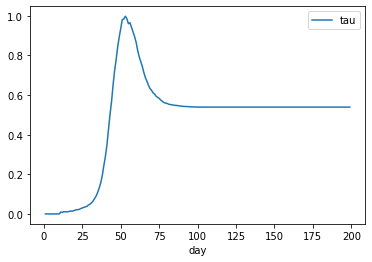

In [15]:
tauPerDay = analyserBasic.getTauPerDay()
tauPerDayBaseline = pd.DataFrame({'day': range(1,200), 'tau': tauPerDay})
tauPerDayBaseline.plot('day')

### Now change the multiplier to be completely random every simulation step from a uniform distribution
We expect to see a uniform distribution, and thus a mean of 0.5 and a standard deviation of 0.08333.
The overall number of infected may well change, as now the overall probability distribution across all interactions will be different from the three network types' fixed values.

Mean of r0 estimate:  1.0703423041180065 , variance of r0 estimate:  0.00923523348053402 , Max R0:  1.3075254463540797
WORK:     Count of networks:  5.0 , Mean:  0.5051788061943371 , Variance:  0.07923206948664943
HOME:     Count of networks:  1.0 , Mean:  1.026897045013029 , Variance:  0.3380708126679793
RANDOM:   Count of networks:  1.0 , Mean:  0.4976353564974852 , Variance:  0.08201530388487145


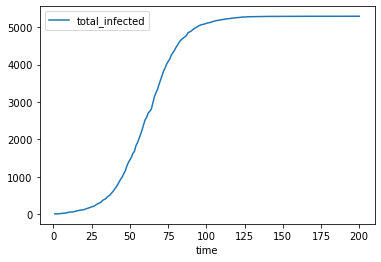

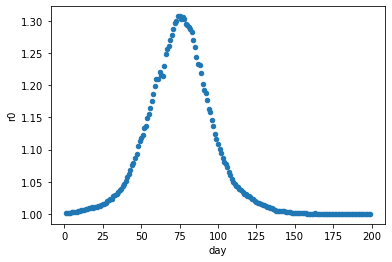

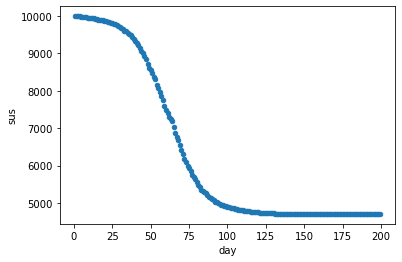

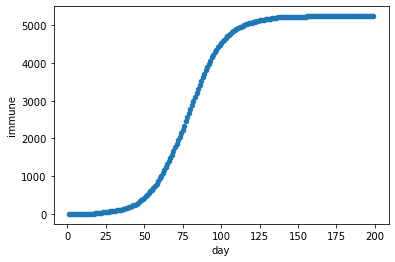

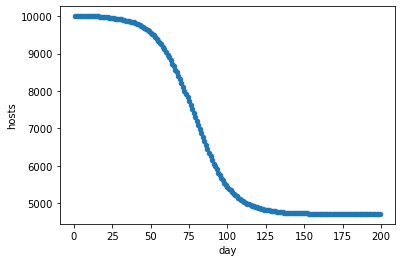

In [16]:
import numpy as np

from scipy.stats import uniform 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
params.set_param( "n_total", 10000)

model = simulation.COVID19IBM(model = Model(params))

sim   = simulation.Simulation(env = model, end_time = 200 )

underlyingModel = sim.env.model

randomValue = 0

valuesWork = []
valuesHome = []
valuesRandom = []

susceptiblesPerDay = []
immunePerDay = []
hostsPerDay = []
r0PerDay = []

for b in range(1,201):
    # Modify network probabilities each step
    for networkId in range(underlyingModel.c_model.n_networks):
        network = underlyingModel.get_network_by_id(networkId)
        
        randomValue = uniform.rvs(0.0,1.0)
        
        network.set_network_transmission_multiplier(randomValue)
        
        if network.type() == 0:
            valuesHome.append(network.transmission_multiplier_combined())
        elif network.type() == 1:
            valuesWork.append(network.transmission_multiplier_combined())
        elif network.type() == 2:
            valuesRandom.append(network.transmission_multiplier_combined())
        # See constant.h:155 INTERACTION_TYPE enum for other types (hospital networks)
    
    # Calculate R0 estimate - R = 1/ x* = 1 / (X / N) = N / X (equilibrium),
    # where N is total number of hosts, X is susceptible hosts
    # from Anderson & May Chapter 4 page 69 (The basic model: statics)
    xBar = 0
    nBar = 0
    immuneBar = 0
    indivs = underlyingModel.get_individuals()
    for indivId in range(n_total):
        indivStatus = indivs.current_status[indivId]
        if indivStatus == 0:
            # Susceptible
            xBar += 1
            nBar += 1
            
        # 10=Death - not allowed for in Anderson & May, so discount
        # 21=Mortuary - again not allowed for
        # 9=Recovered (and immune by default in our sim run), so discount? (NO!)
        elif indivStatus == 9:
            #nBar += 1
            immuneBar += 1
        elif (indivStatus != 10) and (indivStatus != 21): # and (indivStatus != 9):
            # Infected or infectious or recovering
            nBar += 1
    
    if b > 1:
        susceptiblesPerDay.append(xBar)
        hostsPerDay.append(nBar)
        immunePerDay.append(immuneBar)
        if xBar != 0:
            r0PerDay.append(nBar / xBar)
        else:
            r0PerDay.append(0)
    
    # Run sim
    sim.steps(1)

# Now calculate Mean and Variance over r0, for days when we have valid susceptibles
validDays = 0
totalR0s = 0
maxR0 = 0
for d in range(0,199):
    if susceptiblesPerDay[d] != 0:
        validDays += 1
        totalR0s += r0PerDay[d]
        if r0PerDay[d] > maxR0:
            maxR0 = r0PerDay[d]
        
# Calculate mean
meanR0 = 0
if validDays > 0:
    meanR0 = totalR0s / validDays
# Calculate variance
totalR0Deviations = 0
varianceR0 = 0
if meanR0 > 0 and validDays > 1: # Sample variance, so need at least 2 days worth of data
    for d in range(0,199):
        if susceptiblesPerDay[d] != 0:
            totalR0Deviations += pow(r0PerDay[d] - meanR0,2)
    varianceR0 = totalR0Deviations / (validDays - 1)
        
timeseriesUniform = pd.DataFrame( sim.results )
timeseriesUniform.plot( x = "time", y = "total_infected" )

r0Uniform = pd.DataFrame({'day': range(1,200), 'r0': r0PerDay})
r0Uniform.plot('day','r0', kind = 'scatter')

xnUniformSus = pd.DataFrame({'day': range(1,200), 'sus': susceptiblesPerDay})
xnUniformSus.plot('day','sus',kind='scatter')
xnUniformImmune = pd.DataFrame({'day': range(1,200), 'immune': immunePerDay})
xnUniformImmune.plot('day','immune',kind='scatter')
xnUniformHosts = pd.DataFrame({'day': range(1,200), 'hosts': hostsPerDay})
xnUniformHosts.plot('day','hosts',kind='scatter')

print("Mean of r0 estimate: ",meanR0,", variance of r0 estimate: ",varianceR0, ", Max R0: ",maxR0)    


# Now generate the mean and variance results
countWork = len(valuesWork)
totalWork = 0
for a in range(countWork):
    totalWork += valuesWork[a]
meanWork = totalWork / countWork
totalVarianceWork = 0
for a in range(countWork):
    totalVarianceWork += pow(valuesWork[a] - meanWork,2)
varianceWork = totalVarianceWork / countWork
print("WORK:     Count of networks: ",countWork/200,", Mean: ",meanWork,", Variance: ",varianceWork)

countHome = len(valuesHome)
if countHome > 0:
    totalHome = 0
    for a in range(countHome):
        totalHome += valuesHome[a]
    meanHome = totalHome / countHome
    totalVarianceHome = 0
    for a in range(countHome):
        totalVarianceHome += pow(valuesHome[a] - meanHome,2)
    varianceHome = totalVarianceHome / countHome
    print("HOME:     Count of networks: ",countHome/200,", Mean: ",meanHome,", Variance: ",varianceHome)
else:
    print("HOME:     No home networks")
    
countRandom = len(valuesRandom)
if countRandom > 0:
    totalRandom = 0
    for a in range(countRandom):
        totalRandom += valuesRandom[a]
    meanRandom = totalRandom / countRandom
    totalVarianceRandom = 0
    for a in range(countRandom):
        totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
    varianceRandom = totalVarianceRandom / countRandom
    print("RANDOM:   Count of networks: ",countRandom/200,", Mean: ",meanRandom,", Variance: ",varianceRandom)
else:
    print("RANDOM:   No random networks")

### Now do the same but from a Gamma distribution and random every simulation step
We expect to see the same mean and variance at a population level with the gamma distribution with Scale 1.

We expect to see more infections earlier on due to the skewness of the CDF of the gamma distribution when compared to a uniform distribution.

Mean of r0 estimate:  1.2256982375951122 , variance of r0 estimate:  0.22779406738992453 , Max R0:  2.8386317907444667
WORK:     Count of networks:  5.0 , Mean:  1.010158418637904 , Variance:  1.1170483023032194
HOME:     Count of networks:  1.0 , Mean:  1.8427378664899152 , Variance:  3.3401800826164094
RANDOM:   Count of networks:  1.0 , Mean:  0.9599303891585441 , Variance:  0.9671415901373881


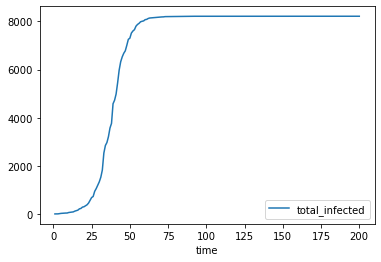

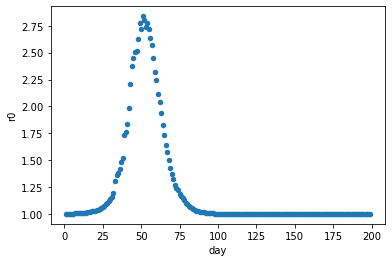

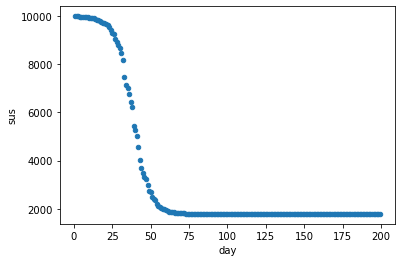

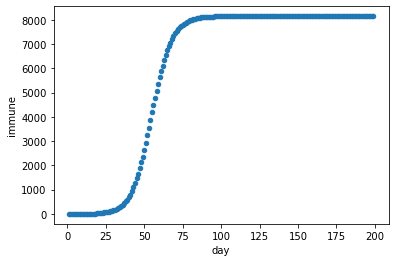

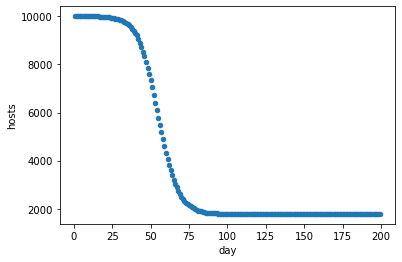

In [17]:
import numpy as np

from scipy.stats import gamma 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
params.set_param( "n_total", 10000)

model = simulation.COVID19IBM(model = Model(params))

sim   = simulation.Simulation(env = model, end_time = 200 )

underlyingModel = sim.env.model

randomValue = 0

valuesWork = []
valuesHome = []
valuesRandom = []

susceptiblesPerDay = []
immunePerDay = []
hostsPerDay = []
r0PerDay = []

for b in range(1,201):
    # Modify network probabilities each step
    for networkId in range(0,underlyingModel.c_model.n_networks):
        network = underlyingModel.get_network_by_id(networkId)
        
        randomValue = gamma.rvs(1,scale=1)
        
        network.set_network_transmission_multiplier(randomValue)
        
        if network.type() == 0:
            valuesHome.append(network.transmission_multiplier_combined())
        elif network.type() == 1:
            valuesWork.append(network.transmission_multiplier_combined())
        elif network.type() == 2:
            valuesRandom.append(network.transmission_multiplier_combined())
        # See constant.h:155 INTERACTION_TYPE enum for other types (hospital networks)
                    
    
    # Calculate R0 estimate - R = 1/ x* = 1 / (X / N) = N / X (equilibrium),
    # where N is total number of hosts, X is susceptible hosts
    # from Anderson & May Chapter 4 page 69 (The basic model: statics)
    xBar = 0
    nBar = 0
    immuneBar = 0
    indivs = underlyingModel.get_individuals()
    for indivId in range(n_total):
        indivStatus = indivs.current_status[indivId]
        if indivStatus == 0:
            # Susceptible
            xBar += 1
            nBar += 1
            
        # 10=Death - not allowed for in Anderson & May, so discount
        # 21=Mortuary - again not allowed for
        # 9=Recovered (and immune by default in our sim run), so discount? (NO!)
        elif indivStatus == 9:
            #nBar += 1
            immuneBar += 1
        elif (indivStatus != 10) and (indivStatus != 21): # and (indivStatus != 9):
            # Infected or infectious (no longer: or recovering)
            nBar += 1
    
    if b > 1:
        susceptiblesPerDay.append(xBar)
        hostsPerDay.append(nBar)
        immunePerDay.append(immuneBar)
        if xBar != 0:
            r0PerDay.append(nBar / xBar)
        else:
            r0PerDay.append(0)
              
    
    # Run sim
    sim.steps(1)

# Now calculate Mean and Variance over r0, for days when we have valid susceptibles
validDays = 0
totalR0s = 0
maxR0 = 0
for d in range(0,199):
    if susceptiblesPerDay[d] != 0:
        validDays += 1
        totalR0s += r0PerDay[d]
        if r0PerDay[d] > maxR0:
            maxR0 = r0PerDay[d]
        
# Calculate mean
meanR0 = 0
if validDays > 0:
    meanR0 = totalR0s / validDays
# Calculate variance
totalR0Deviations = 0
varianceR0 = 0
if meanR0 > 0 and validDays > 1: # Sample variance, so need at least 2 days worth of data
    for d in range(0,199):
        if susceptiblesPerDay[d] != 0:
            totalR0Deviations += pow(r0PerDay[d] - meanR0,2)
    varianceR0 = totalR0Deviations / (validDays - 1)
          
timeseriesGamma = pd.DataFrame( sim.results )
timeseriesGamma.plot( x = "time", y = "total_infected" )

r0Gamma = pd.DataFrame({'day': range(1,200), 'r0': r0PerDay})
r0Gamma.plot('day','r0', kind = 'scatter')

xnGammaSus = pd.DataFrame({'day': range(1,200), 'sus': susceptiblesPerDay})
xnGammaSus.plot('day','sus',kind='scatter')
xnGammaImmune = pd.DataFrame({'day': range(1,200), 'immune': immunePerDay})
xnGammaImmune.plot('day','immune',kind='scatter')
xnGammaHosts = pd.DataFrame({'day': range(1,200), 'hosts': hostsPerDay})
xnGammaHosts.plot('day','hosts',kind='scatter')

print("Mean of r0 estimate: ",meanR0,", variance of r0 estimate: ",varianceR0, ", Max R0: ",maxR0)    


# Now generate the mean and variance results
countWork = len(valuesWork)
totalWork = 0
for a in range(countWork):
    totalWork += valuesWork[a]
meanWork = totalWork / countWork
totalVarianceWork = 0
for a in range(countWork):
    totalVarianceWork += pow(valuesWork[a] - meanWork,2)
varianceWork = totalVarianceWork / countWork
print("WORK:     Count of networks: ",countWork/200,", Mean: ",meanWork,", Variance: ",varianceWork)

countHome = len(valuesHome)
if countHome > 0:
    totalHome = 0
    for a in range(countHome):
        totalHome += valuesHome[a]
    meanHome = totalHome / countHome
    totalVarianceHome = 0
    for a in range(countHome):
        totalVarianceHome += pow(valuesHome[a] - meanHome,2)
    varianceHome = totalVarianceHome / countHome
    print("HOME:     Count of networks: ",countHome/200,", Mean: ",meanHome,", Variance: ",varianceHome)
else:
    print("HOME:     No home networks")
    
countRandom = len(valuesRandom)
if countRandom > 0:
    totalRandom = 0
    for a in range(countRandom):
        totalRandom += valuesRandom[a]
    meanRandom = totalRandom / countRandom
    totalVarianceRandom = 0
    for a in range(countRandom):
        totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
    varianceRandom = totalVarianceRandom / countRandom
    print("RANDOM:   Count of networks: ",countRandom/200,", Mean: ",meanRandom,", Variance: ",varianceRandom)
else:
    print("RANDOM:   No random networks")

### Now create multiple network instances of the same type and see if it produces the same results
We want to move to a model where an individuals workplace is modelled exactly. This means we need multiple home and work networks simulated with different transmission probabilities rather than a single work instance with the same one and just a proportion of mixing happening within the network.
Let us modify the model to have 200 work places and 4000 homes but keep the 5 random networks. Let us use the same fixed probabilities as the original baseline parameters.
We should see the same infection curve as the baseline model with the same means and zero variance.

Network state from parameters file:-
Network 0 is a Random network
Network 1 is a Home network
Network 2 is a Work network
Network 3 is a Work network
Network 4 is a Work network
Network 5 is a Work network
Network 6 is a Work network
Network state after modification:-
Network 0 is a Random network
Network 1 is a Home network
Network 2 is a Work network
Network 3 is a Work network
Network 4 is a Work network
Network 5 is a Work network
Network 6 is a Work network
Network 7 is a Work network
Network 8 is a Work network
Network 9 is a Work network
Network 10 is a Work network
Network 11 is a Work network
Network 12 is a Work network
Network 13 is a Work network
Network 14 is a Work network
Network 15 is a Work network
Network 16 is a Work network
Network 17 is a Work network
Network 18 is a Work network
Network 19 is a Work network
Network 20 is a Work network
Network 21 is a Work network
Mean of r0 estimate:  1.3135264758326337 , variance of r0 estimate:  0.49549049771720444 , Max R0:  

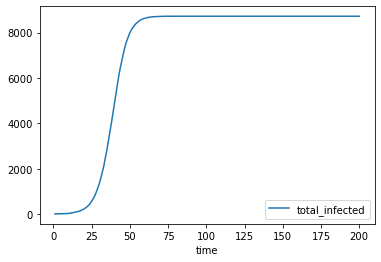

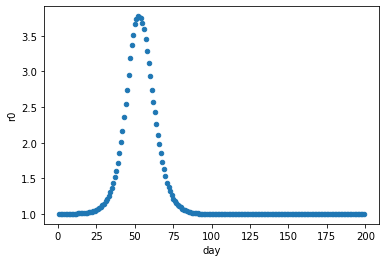

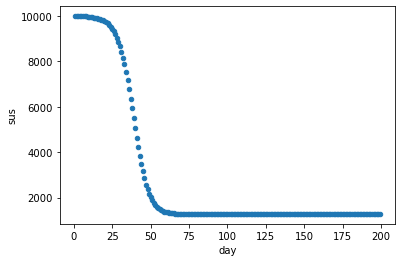

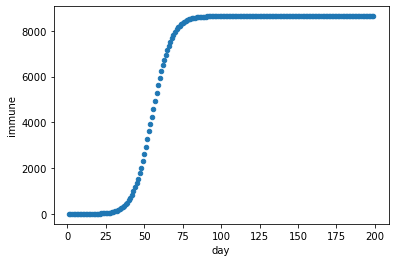

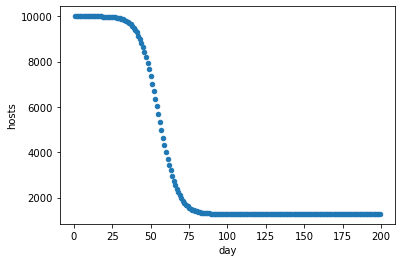

In [18]:
import numpy as np
import example_utils as utils
from scipy.stats import gamma 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
n_total = 10000
params.set_param( "n_total", n_total)

model = simulation.COVID19IBM(model = Model(params))

sim   = simulation.Simulation(env = model, end_time = 200 )

underlyingModel = sim.env.model

randomValue = 0

valuesWork = []
valuesHome = []
valuesRandom = []

susceptiblesPerDay = []
immunePerDay = []
hostsPerDay = []
r0PerDay = []

# These are from the baseline parameters csv file - mean_*_interactions_adult parameters
meanWorkInteraction = 7
meanHomeInteraction = 4
meanRandomInteraction = 4

# Print existing network info:-
print("Network state from parameters file:-")
for networkId in range(0,underlyingModel.c_model.n_networks):
    network = underlyingModel.get_network_by_id(networkId)

    if network.type() == 0:
        print("Network",networkId,"is a Home network")
    elif network.type() == 1:
        print("Network",networkId,"is a Work network")
    elif network.type() == 2:
        print("Network",networkId,"is a Random network")
    else: 
        print("Network",networkId,"is something else")


        
        
        
        

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
n_total = 10000
params.set_param( "n_total", n_total)

# REMOVE ALL DEFAULT NETWORKS
# Note: We cannot currently delete parameters from the Parameter object in OpenABM-Covid19
        
# Duplicate initial networks, and if work or occupation network, create 20x the number
# doneHome = False
# doneWork = False
# for networkId in range(0,underlyingModel.c_model.n_networks):
#     network = underlyingModel.get_network_by_id(networkId)
#     if network.type() == 0 and not doneHome:
#         doneHome = True
#         # Home network - create 19 copies, each with a different probability
#         n_total = network.n_vertices() / 20
#         parameters = params
#         for nc in range(1,20):
#             newNetwork = underlyingModel.create_network(n_total,network.type(),parameters)
# #             randomValue = gamma.rvs(1,scale=1)
# #             newNetwork.set_network_transmission_multiplier(randomValue)
#         # Modify original network
#         network.n_vertices = n_total
        
# #     elif network.type() == 1:
#         # Do nothing - keep 5!
#         #
#     elif network.type() != 0 and network.type() != 1 and not doneWork:
#         doneWork = True
#         # Work network - create 19 copies, each with a different probability
#         n_total = network.n_vertices() / 20
#         parameters = params
#         for nc in range(1,20):
#             newNetwork = underlyingModel.create_network(n_total,network.type(),parameters)
# #             randomValue = gamma.rvs(1,scale=1)
# #             newNetwork.set_network_transmission_multiplier(randomValue)
#         # Modify original network
#         network.n_vertices = n_total

n_networks = 20
network_no = np.arange(n_networks)
network_name = np.array(['e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9', 'e10','e11', 'e12', 'e13', 'e14', 'e15', 'e16', 'e17', 'e18', 'e19', 'e20'])
age_type = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]) # 0 - AGE_TYPE_CHILD, 1 - AGE_TYPE_ADULT, 2 - AGE_TYPE_ELDERLY
mean_work_interaction = np.array([7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7])
lockdown_multiplier = np.ones(n_networks) * 0.33 # From parameters file lockdown_occupation_multiplier_*_network

occupation_networks = pd.DataFrame({
    'network_no': network_no,
    'age_type': age_type,
    'mean_work_interaction': mean_work_interaction,
    'lockdown_multiplier': lockdown_multiplier,
    'network_id': network_no,
    'network_name': network_name,
})
IDs = np.arange(n_total)
assignment = np.random.randint(0, n_networks, n_total)
occupation_network_assignment  = pd.DataFrame({'ID':IDs, 'network_no':assignment})
params.set_occupation_network_table(occupation_network_assignment, occupation_networks)



# WARNING - THE ABOVE EFFECTIVELY REMOVES ALL NETWORKS WITH IDS < 20 - ALL THE ORIGINAL NETWORKS!
# Need something like params.set_demographic_house_table(n_total,...) but which allocates the people like occupation network call above


# Now home networks - FUNCTIONALITY NOT AVAILABLE WITHIN OPENABM COVID19 TODAY!

# n_networks = 20
# network_no = 20 + np.arange(n_networks)
# network_name = np.array(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10','h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20'])
# age_type = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]) # 0 - AGE_TYPE_CHILD, 1 - AGE_TYPE_ADULT, 2 - AGE_TYPE_ELDERLY
# mean_home_interaction = np.array([7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7])
# lockdown_multiplier = np.ones(n_networks) * 0.22

# home_networks = pd.DataFrame({
#     'network_no': network_no,
#     'age_type': age_type,
#     'mean_work_interaction': mean_home_interaction,
#     'lockdown_multiplier': lockdown_multiplier,
#     'network_id': network_no,
#     'network_name': network_name,
# })
# IDs = 20 + np.arange(n_total)
# assignment = np.random.randint(0, n_networks, n_total)
# home_network_assignment  = pd.DataFrame({'ID':IDs, 'network_no':assignment})
# params.set_home_network_table(home_network_assignment, home_networks)






# model = simulation.COVID19IBM(model = Model(params))
# Reload parameters (otherwise you get an 'already loaded into model' error)
sim = utils.get_simulation( params )
underlyingModel = sim.env.model

for b in range(1,201):
    # Modify network probabilities each step
    if (1 == b):
        print("Network state after modification:-")
    for networkId in range(0,underlyingModel.c_model.n_networks):
        network = underlyingModel.get_network_by_id(networkId)
        if (1 == b):
            if network.type() == 0:
                print("Network",networkId,"is a Home network")
            elif network.type() == 1:
                print("Network",networkId,"is a Work network")
            elif network.type() == 2:
                print("Network",networkId,"is a Random network")
            else: 
                print("Network",networkId,"is something else")
        
#         randomValue = gamma.rvs(1,scale=1)
        
#         network.set_network_transmission_multiplier(randomValue)
        
        if network.type() == 0:
            valuesHome.append(network.transmission_multiplier_combined())
        elif network.type() == 1:
            valuesWork.append(network.transmission_multiplier_combined())
        elif network.type() == 2:
            valuesRandom.append(network.transmission_multiplier_combined())
        # See constant.h:155 INTERACTION_TYPE enum for other types (hospital networks)
                    
        
    # Calculate R0 estimate - R = 1/ x* = 1 / (X / N) = N / X (equilibrium),
    # where N is total number of hosts, X is susceptible hosts
    # from Anderson & May Chapter 4 page 69 (The basic model: statics)
    xBar = 0
    nBar = 0
    immuneBar = 0
    indivs = underlyingModel.get_individuals()
    for indivId in range(n_total):
        indivStatus = indivs.current_status[indivId]
        if indivStatus == 0:
            # Susceptible
            xBar += 1
            nBar += 1
            
        # 10=Death - not allowed for in Anderson & May, so discount
        # 21=Mortuary - again not allowed for
        # 9=Recovered (and immune by default in our sim run), so discount? (NO!)
        elif indivStatus == 9:
            #nBar += 1
            immuneBar += 1
        elif (indivStatus != 10) and (indivStatus != 21): # and (indivStatus != 9):
            # Infected or infectious (no longer: or recovering)
            nBar += 1
    
    if b > 1:
        susceptiblesPerDay.append(xBar)
        hostsPerDay.append(nBar)
        immunePerDay.append(immuneBar)
        if xBar != 0:
            r0PerDay.append(nBar / xBar)
        else:
            r0PerDay.append(0)
              
    
    # Run sim
    sim.steps(1)

# Now calculate Mean and Variance over r0, for days when we have valid susceptibles
validDays = 0
totalR0s = 0
maxR0 = 0
for d in range(0,199):
    if susceptiblesPerDay[d] != 0:
        validDays += 1
        totalR0s += r0PerDay[d]
        if r0PerDay[d] > maxR0:
            maxR0 = r0PerDay[d]
        
# Calculate mean
meanR0 = 0
if validDays > 0:
    meanR0 = totalR0s / validDays
# Calculate variance
totalR0Deviations = 0
varianceR0 = 0
if meanR0 > 0 and validDays > 1: # Sample variance, so need at least 2 days worth of data
    for d in range(0,199):
        if susceptiblesPerDay[d] != 0:
            totalR0Deviations += pow(r0PerDay[d] - meanR0,2)
    varianceR0 = totalR0Deviations / (validDays - 1)
          
timeseriesMulti = pd.DataFrame( sim.results )
timeseriesMulti.plot( x = "time", y = "total_infected" )

r0Multi = pd.DataFrame({'day': range(1,200), 'r0': r0PerDay})
r0Multi.plot('day','r0', kind = 'scatter')

xnMultiSus = pd.DataFrame({'day': range(1,200), 'sus': susceptiblesPerDay})
xnMultiSus.plot('day','sus',kind='scatter')
xnMultiImmune = pd.DataFrame({'day': range(1,200), 'immune': immunePerDay})
xnMultiImmune.plot('day','immune',kind='scatter')
xnMultiHosts = pd.DataFrame({'day': range(1,200), 'hosts': hostsPerDay})
xnMultiHosts.plot('day','hosts',kind='scatter')

print("Mean of r0 estimate: ",meanR0,", variance of r0 estimate: ",varianceR0, ", Max R0: ",maxR0)    


# Now generate the mean and variance results
countWork = len(valuesWork)
totalWork = 0
for a in range(countWork):
    totalWork += valuesWork[a]
meanWork = totalWork / countWork
totalVarianceWork = 0
for a in range(countWork):
    totalVarianceWork += pow(valuesWork[a] - meanWork,2)
varianceWork = totalVarianceWork / countWork
print("WORK:     Count of networks: ",countWork/200,", Mean: ",meanWork,", Variance: ",varianceWork)

countHome = len(valuesHome)
if countHome > 0:
    totalHome = 0
    for a in range(countHome):
        totalHome += valuesHome[a]
    meanHome = totalHome / countHome
    totalVarianceHome = 0
    for a in range(countHome):
        totalVarianceHome += pow(valuesHome[a] - meanHome,2)
    varianceHome = totalVarianceHome / countHome
    print("HOME:     Count of networks: ",countHome/200,", Mean: ",meanHome,", Variance: ",varianceHome)
else:
    print("HOME:     No home networks")
    
countRandom = len(valuesRandom)
if countRandom > 0:
    totalRandom = 0
    for a in range(countRandom):
        totalRandom += valuesRandom[a]
    meanRandom = totalRandom / countRandom
    totalVarianceRandom = 0
    for a in range(countRandom):
        totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
    varianceRandom = totalVarianceRandom / countRandom
    print("RANDOM:   Count of networks: ",countRandom/200,", Mean: ",meanRandom,", Variance: ",varianceRandom)
else:
    print("RANDOM:   No random networks")

### Now reintroduce the Gamma distribution
We now modify the networks so they use the gamma distribution (shape=1), but with a transmission probability fixed for each network instance (not network type as in the baseline) at the start of the simulation, but with many more networks.
Again we expect to see the same infection curve but with variance matching our previous gamma model (0.0367) and mean for the distribution (~1.0).

Mean of r0 estimate:  1.1937805164249635 , variance of r0 estimate:  0.17193720437059162 , Max R0:  2.5791936645068394
WORK:     Count of networks:  200.0 , Mean:  0.8904817167421104 , Variance:  0.8326125507849365
HOME:     Count of networks:  1.0 , Mean:  2.0 , Variance:  0.0
RANDOM:   Count of networks:  1.0 , Mean:  1.0 , Variance:  0.0


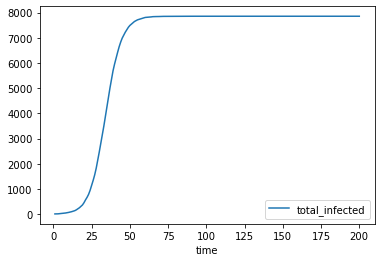

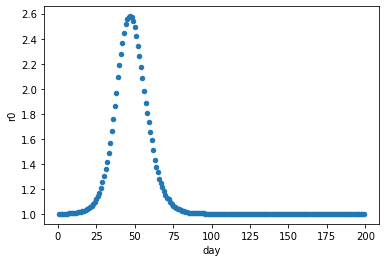

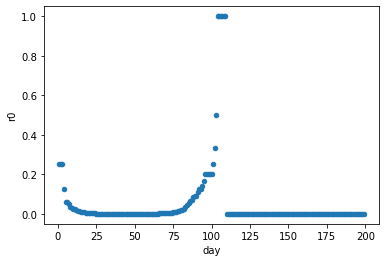

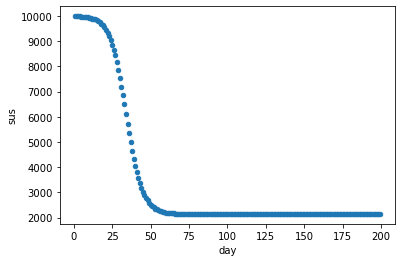

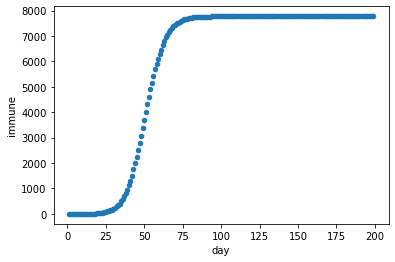

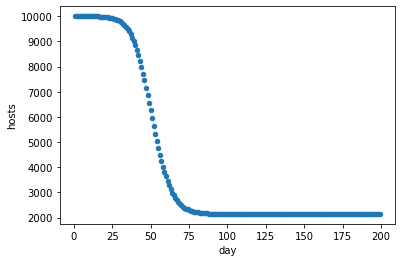

In [19]:
import numpy as np
import example_utils as utils
from scipy.stats import gamma 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
n_total = 10000
params.set_param( "n_total", n_total)

model = simulation.COVID19IBM(model = Model(params))

sim   = simulation.Simulation(env = model, end_time = 200 )

underlyingModel = sim.env.model

randomValue = 0

valuesWork = []
valuesHome = []
valuesRandom = []

susceptiblesPerDay = []
immunePerDay = []
infectiousPerDay = []
hostsPerDay = []
r0PerDay = []
r0InfPerDay = []

# These are from the baseline parameters csv file - mean_*_interactions_adult parameters
meanWorkInteraction = 7
meanHomeInteraction = 4
meanRandomInteraction = 4

# Print existing network info:-
# print("Network state from parameters file:-")
# for networkId in range(0,underlyingModel.c_model.n_networks):
#     network = underlyingModel.get_network_by_id(networkId)

#     if network.type() == 0:
#         print("Network",networkId,"is a Home network")
#     elif network.type() == 1:
#         print("Network",networkId,"is a Work network")
#     elif network.type() == 2:
#         print("Network",networkId,"is a Random network")
#     else: 
#         print("Network",networkId,"is something else")

 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
n_total = 10000
params.set_param( "n_total", n_total)

# REMOVE ALL DEFAULT NETWORKS
# Note: We cannot currently delete parameters from the Parameter object in OpenABM-Covid19
#       So we just overwrite them instead

n_networks = 200
network_no = np.arange(n_networks)
network_name_array = []
age_type_array = []
mean_work_interaction_array = []
for i in range (1,1 + n_networks):
    network_name_array.append("e" + str(i))
    age_type_array.append(1)
    mean_work_interaction_array.append(meanWorkInteraction)
network_name = np.array(network_name_array)
age_type = np.array(age_type_array) # 0 - AGE_TYPE_CHILD, 1 - AGE_TYPE_ADULT, 2 - AGE_TYPE_ELDERLY
mean_work_interaction = np.array(mean_work_interaction_array)
lockdown_multiplier = np.ones(n_networks) * 0.33 # From parameters file lockdown_occupation_multiplier_*_network

occupation_networks = pd.DataFrame({
    'network_no': network_no,
    'age_type': age_type,
    'mean_work_interaction': mean_work_interaction,
    'lockdown_multiplier': lockdown_multiplier,
    'network_id': network_no,
    'network_name': network_name,
})
IDs = np.arange(n_total)
assignment = np.random.randint(0, n_networks, n_total)
occupation_network_assignment  = pd.DataFrame({'ID':IDs, 'network_no':assignment})
params.set_occupation_network_table(occupation_network_assignment, occupation_networks)



# WARNING - THE ABOVE EFFECTIVELY REMOVES ALL NETWORKS WITH IDS < 20 - ALL THE ORIGINAL NETWORKS!
# Need something like params.set_demographic_house_table(n_total,...) but which allocates the people like occupation network call above


# Now home networks - FUNCTIONALITY NOT AVAILABLE WITHIN OPENABM COVID19 TODAY!

# n_networks = 20
# network_no = 20 + np.arange(n_networks)
# network_name = np.array(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10','h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20'])
# age_type = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]) # 0 - AGE_TYPE_CHILD, 1 - AGE_TYPE_ADULT, 2 - AGE_TYPE_ELDERLY
# mean_home_interaction = np.array([7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7])
# lockdown_multiplier = np.ones(n_networks) * 0.22

# home_networks = pd.DataFrame({
#     'network_no': network_no,
#     'age_type': age_type,
#     'mean_work_interaction': mean_home_interaction,
#     'lockdown_multiplier': lockdown_multiplier,
#     'network_id': network_no,
#     'network_name': network_name,
# })
# IDs = 20 + np.arange(n_total)
# assignment = np.random.randint(0, n_networks, n_total)
# home_network_assignment  = pd.DataFrame({'ID':IDs, 'network_no':assignment})
# params.set_home_network_table(home_network_assignment, home_networks)




# model = simulation.COVID19IBM(model = Model(params))
# Reload parameters (otherwise you get an 'already loaded into model' error)
sim = utils.get_simulation( params )
underlyingModel = sim.env.model

# Pre-select all probabilities
probs = []
for networkId in range(0,underlyingModel.c_model.n_networks):
    probs.append(gamma.rvs(1,scale=1))
    
for b in range(1,201):
    # Modify network probabilities each step
#     if (1 == b):
#         print("Network state after modification:-")
    for networkId in range(0,underlyingModel.c_model.n_networks):
        network = underlyingModel.get_network_by_id(networkId)
#         if (1 == b):
#             if network.type() == 0:
#                 print("Network",networkId,"is a Home network")
#             elif network.type() == 1:
#                 print("Network",networkId,"is a Work network")
#             elif network.type() == 2:
#                 print("Network",networkId,"is a Random network")
#             else: 
#                 print("Network",networkId,"is something else")
        
        if network.type() == 0:
            valuesHome.append(network.transmission_multiplier_combined())
        elif network.type() == 1:
            valuesWork.append(network.transmission_multiplier_combined())
                
            randomValue = probs[networkId]
            network.set_network_transmission_multiplier(randomValue)
        elif network.type() == 2:
            valuesRandom.append(network.transmission_multiplier_combined())
        # See constant.h:155 INTERACTION_TYPE enum for other types (hospital networks)
                    
        
    # Calculate R0 estimate - R = 1/ x* = 1 / (X / N) = N / X (equilibrium),
    # where N is total number of hosts, X is susceptible hosts
    # from Anderson & May Chapter 4 page 69 (The basic model: statics)
    xBar = 0
    nBar = 0
    immuneBar = 0
    infectiousBar = 0
    indivs = underlyingModel.get_individuals()
    for indivId in range(n_total):
        indivStatus = indivs.current_status[indivId]
        if indivStatus == 0:
            # Susceptible
            xBar += 1
            nBar += 1
            
        # 10=Death - not allowed for in Anderson & May, so discount
        # 21=Mortuary - again not allowed for
        # 9=Recovered (and immune by default in our sim run), so discount? (NO!)
        elif indivStatus == 9:
            #nBar += 1
            immuneBar += 1
        elif (indivStatus == 3) or (indivStatus == 4) or (indivStatus == 5):
            # Infectious
            infectiousBar += 1
            nBar += 1
        elif (indivStatus != 10) and (indivStatus != 21): # and (indivStatus != 9):
            # Infected or infectious (no longer: or recovering)
            nBar += 1
    
    if b > 1:
        susceptiblesPerDay.append(xBar)
        hostsPerDay.append(nBar)
        immunePerDay.append(immuneBar)
        infectiousPerDay.append(infectiousBar)
        if xBar != 0:
            r0PerDay.append(nBar / xBar)
        else:
            r0PerDay.append(0)
        if (xBar != 0) and (infectiousBar != 0):
            r0InfPerDay.append(nBar / (xBar * infectiousBar))
        else:
            r0InfPerDay.append(0)
              
    
    # Run sim
    sim.steps(1)

# Now calculate Mean and Variance over r0, for days when we have valid susceptibles
validDays = 0
totalR0s = 0
maxR0 = 0
for d in range(0,199):
    if susceptiblesPerDay[d] != 0:
        validDays += 1
        totalR0s += r0PerDay[d]
        if r0PerDay[d] > maxR0:
            maxR0 = r0PerDay[d]
        
# Calculate mean
meanR0 = 0
if validDays > 0:
    meanR0 = totalR0s / validDays
# Calculate variance
totalR0Deviations = 0
varianceR0 = 0
if meanR0 > 0 and validDays > 1: # Sample variance, so need at least 2 days worth of data
    for d in range(0,199):
        if susceptiblesPerDay[d] != 0:
            totalR0Deviations += pow(r0PerDay[d] - meanR0,2)
    varianceR0 = totalR0Deviations / (validDays - 1)
          
timeseriesMultiStart = pd.DataFrame( sim.results )
timeseriesMultiStart.plot( x = "time", y = "total_infected" )

r0MultiStart = pd.DataFrame({'day': range(1,200), 'r0': r0PerDay})
r0MultiStart.plot('day','r0', kind = 'scatter')

r0InfMultiStart = pd.DataFrame({'day': range(1,200), 'r0': r0InfPerDay})
r0InfMultiStart.plot('day','r0', kind = 'scatter')

xnMultiStartSus = pd.DataFrame({'day': range(1,200), 'sus': susceptiblesPerDay})
xnMultiStartSus.plot('day','sus',kind='scatter')
xnMultiStartImmune = pd.DataFrame({'day': range(1,200), 'immune': immunePerDay})
xnMultiStartImmune.plot('day','immune',kind='scatter')
xnMultiStartHosts = pd.DataFrame({'day': range(1,200), 'hosts': hostsPerDay})
xnMultiStartHosts.plot('day','hosts',kind='scatter')

print("Mean of r0 estimate: ",meanR0,", variance of r0 estimate: ",varianceR0, ", Max R0: ",maxR0)    

    

# Now generate the mean and variance results
countWork = len(valuesWork)
totalWork = 0
for a in range(countWork):
    totalWork += valuesWork[a]
meanWork = totalWork / countWork
totalVarianceWork = 0
for a in range(countWork):
    totalVarianceWork += pow(valuesWork[a] - meanWork,2)
varianceWork = totalVarianceWork / countWork
print("WORK:     Count of networks: ",countWork/200,", Mean: ",meanWork,", Variance: ",varianceWork)

countHome = len(valuesHome)
if countHome > 0:
    totalHome = 0
    for a in range(countHome):
        totalHome += valuesHome[a]
    meanHome = totalHome / countHome
    totalVarianceHome = 0
    for a in range(countHome):
        totalVarianceHome += pow(valuesHome[a] - meanHome,2)
    varianceHome = totalVarianceHome / countHome
    print("HOME:     Count of networks: ",countHome/200,", Mean: ",meanHome,", Variance: ",varianceHome)
else:
    print("HOME:     No home networks")
    
countRandom = len(valuesRandom)
if countRandom > 0:
    totalRandom = 0
    for a in range(countRandom):
        totalRandom += valuesRandom[a]
    meanRandom = totalRandom / countRandom
    totalVarianceRandom = 0
    for a in range(countRandom):
        totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
    varianceRandom = totalVarianceRandom / countRandom
    print("RANDOM:   Count of networks: ",countRandom/200,", Mean: ",meanRandom,", Variance: ",varianceRandom)
else:
    print("RANDOM:   No random networks")

### Now change the random value to be a weighting from a given mean in the parameter file
We now modify the simulation so the randomness of infection probability lies between being fixed per network type and random for every interaction for every network instance. 
We will use the simulation parameter network transmissability number and treat it as the mean for the chosen distribution, then use the distribution per network instance at the start of the simulation to generate a per network transmissibility number. I.e. it is weighted.
We expect the mean to be the same as the original parameter, but the variance to be the same as the previous gamma set at start simulation.

In [20]:
import numpy as np
import example_utils as utils
from scipy.stats import gamma 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
n_total = 10000
params.set_param( "n_total", n_total)

model = simulation.COVID19IBM(model = Model(params))

sim   = simulation.Simulation(env = model, end_time = 200 )

underlyingModel = sim.env.model

randomValue = 0

valuesWork = []
valuesHome = []
valuesRandom = []

susceptiblesPerDay = []
immunePerDay = []
hostsPerDay = []
r0PerDay = []
r0InfPerDay = []

# These are from the baseline parameters csv file - mean_*_interactions_adult parameters
meanWorkInteraction = 7
meanHomeInteraction = 4
meanRandomInteraction = 4

# Print existing network info:-
# print("Network state from parameters file:-")
# for networkId in range(0,underlyingModel.c_model.n_networks):
#     network = underlyingModel.get_network_by_id(networkId)

#     if network.type() == 0:
#         print("Network",networkId,"is a Home network")
#     elif network.type() == 1:
#         print("Network",networkId,"is a Work network")
#     elif network.type() == 2:
#         print("Network",networkId,"is a Random network")
#     else: 
#         print("Network",networkId,"is something else")

 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
n_total = 10000
params.set_param( "n_total", n_total)

# REMOVE ALL DEFAULT NETWORKS
# Note: We cannot currently delete parameters from the Parameter object in OpenABM-Covid19
#       So we just overwrite them instead

n_networks = 200
network_no = np.arange(n_networks)
network_name_array = []
age_type_array = []
mean_work_interaction_array = []
for i in range (1,1 + n_networks):
    network_name_array.append("e" + str(i))
    age_type_array.append(1)
    mean_work_interaction_array.append(meanWorkInteraction)
network_name = np.array(network_name_array)
age_type = np.array(age_type_array) # 0 - AGE_TYPE_CHILD, 1 - AGE_TYPE_ADULT, 2 - AGE_TYPE_ELDERLY
mean_work_interaction = np.array(mean_work_interaction_array)
lockdown_multiplier = np.ones(n_networks) * 0.33 # From parameters file lockdown_occupation_multiplier_*_network

occupation_networks = pd.DataFrame({
    'network_no': network_no,
    'age_type': age_type,
    'mean_work_interaction': mean_work_interaction,
    'lockdown_multiplier': lockdown_multiplier,
    'network_id': network_no,
    'network_name': network_name,
})
IDs = np.arange(n_total)
assignment = np.random.randint(0, n_networks, n_total)
occupation_network_assignment  = pd.DataFrame({'ID':IDs, 'network_no':assignment})
params.set_occupation_network_table(occupation_network_assignment, occupation_networks)



# WARNING - THE ABOVE EFFECTIVELY REMOVES ALL NETWORKS WITH IDS < 20 - ALL THE ORIGINAL NETWORKS!
# Need something like params.set_demographic_house_table(n_total,...) but which allocates the people like occupation network call above


# Now home networks - FUNCTIONALITY NOT AVAILABLE WITHIN OPENABM COVID19 TODAY!

# n_networks = 20
# network_no = 20 + np.arange(n_networks)
# network_name = np.array(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10','h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20'])
# age_type = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]) # 0 - AGE_TYPE_CHILD, 1 - AGE_TYPE_ADULT, 2 - AGE_TYPE_ELDERLY
# mean_home_interaction = np.array([7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7])
# lockdown_multiplier = np.ones(n_networks) * 0.22

# home_networks = pd.DataFrame({
#     'network_no': network_no,
#     'age_type': age_type,
#     'mean_work_interaction': mean_home_interaction,
#     'lockdown_multiplier': lockdown_multiplier,
#     'network_id': network_no,
#     'network_name': network_name,
# })
# IDs = 20 + np.arange(n_total)
# assignment = np.random.randint(0, n_networks, n_total)
# home_network_assignment  = pd.DataFrame({'ID':IDs, 'network_no':assignment})
# params.set_home_network_table(home_network_assignment, home_networks)




# model = simulation.COVID19IBM(model = Model(params))
# Reload parameters (otherwise you get an 'already loaded into model' error)
sim = utils.get_simulation( params )
underlyingModel = sim.env.model

# Pre-select all probabilities
probs = []
for networkId in range(0,underlyingModel.c_model.n_networks):
    probs.append(1.00 + (0.66*(gamma.rvs(1,scale=1) - 1))) # i.e. 1 (original mean) +/- 0.33 (mean, from params file)

def dayStartCallbackPerNetworkMultiplier(underlyingModel):
    for networkId in range(0,underlyingModel.c_model.n_networks):
        network = underlyingModel.get_network_by_id(networkId)
        
#         if network.type() == 0:
#             valuesHome.append(network.transmission_multiplier_combined())
#         elif 
        if network.type() == 1:
            # Only modification work networks now
            randomValue = probs[networkId]
            network.set_network_transmission_multiplier(randomValue)
            
#             valuesWork.append(network.transmission_multiplier_combined())
#         elif network.type() == 2:
#             valuesRandom.append(network.transmission_multiplier_combined())
        # See constant.h:155 INTERACTION_TYPE enum for other types (hospital networks)
                    
    
# TODO pass in daily function
analyserFinal = analysis.SimulationAnalyser(sim)
analyserFinal.simulateAndAnalyse()


# Collect results
finalTau = analyserFinal.getFinalTau()

# This is optional (compute and memory intensive), so we call it explicitly
analyserFinal.analyseContactEvents()
contactEvents = analyserFinal.getContactEvents() # Only available after running the above


    
    
# for b in range(1,201):
#     # Modify network probabilities each step
# #     if (1 == b):
# #         print("Network state after modification:-")
#     for networkId in range(0,underlyingModel.c_model.n_networks):
#         network = underlyingModel.get_network_by_id(networkId)
# #         if (1 == b):
# #             if network.type() == 0:
# #                 print("Network",networkId,"is a Home network")
# #             elif network.type() == 1:
# #                 print("Network",networkId,"is a Work network")
# #             elif network.type() == 2:
# #                 print("Network",networkId,"is a Random network")
# #             else: 
# #                 print("Network",networkId,"is something else")
        
#         if network.type() == 0:
#             valuesHome.append(network.transmission_multiplier_combined())
#         elif network.type() == 1:
#             # Only modification work networks now
#             randomValue = probs[networkId]
#             network.set_network_transmission_multiplier(randomValue)
            
#             valuesWork.append(network.transmission_multiplier_combined())
#         elif network.type() == 2:
#             valuesRandom.append(network.transmission_multiplier_combined())
#         # See constant.h:155 INTERACTION_TYPE enum for other types (hospital networks)
                    
            
#     # Calculate R0 estimate - R = 1/ x* = 1 / (X / N) = N / X (equilibrium),
#     # where N is total number of hosts, X is susceptible hosts
#     # from Anderson & May Chapter 4 page 69 (The basic model: statics)
#     xBar = 0
#     nBar = 0
#     immuneBar = 0
#     infectiousBar = 0
#     indivs = underlyingModel.get_individuals()
#     for indivId in range(n_total):
#         indivStatus = indivs.current_status[indivId]
#         if indivStatus == 0:
#             # Susceptible
#             xBar += 1
#             nBar += 1
            
#         # 10=Death - not allowed for in Anderson & May, so discount
#         # 21=Mortuary - again not allowed for
#         # 9=Recovered (and immune by default in our sim run), so discount? (NO!)
#         elif indivStatus == 9:
#             #nBar += 1
#             immuneBar += 1
#         elif (indivStatus == 3) or (indivStatus == 4) or (indivStatus == 5):
#             # Infectious
#             infectiousBar += 1
#             nBar += 1
#         elif (indivStatus != 10) and (indivStatus != 21): # and (indivStatus != 9):
#             # Infected or infectious (no longer: or recovering)
#             nBar += 1
    
#     if b > 1:
#         susceptiblesPerDay.append(xBar)
#         hostsPerDay.append(nBar)
#         immunePerDay.append(immuneBar)
#         infectiousPerDay.append(infectiousBar)
#         if xBar != 0:
#             r0PerDay.append(nBar / xBar)
#         else:
#             r0PerDay.append(0)
#         if (xBar != 0) and (infectiousBar != 0):
#             r0InfPerDay.append(nBar / (xBar * infectiousBar))
#         else:
#             r0InfPerDay.append(0)
                  
    
#     # Run sim
#     sim.steps(1)

# # Now calculate Mean and Variance over r0, for days when we have valid susceptibles
# validDays = 0
# totalR0s = 0
# maxR0 = 0
# for d in range(0,199):
#     if susceptiblesPerDay[d] != 0:
#         validDays += 1
#         totalR0s += r0PerDay[d]
#         if r0PerDay[d] > maxR0:
#             maxR0 = r0PerDay[d]
        
# # Calculate mean
# meanR0 = 0
# if validDays > 0:
#     meanR0 = totalR0s / validDays
# # Calculate variance
# totalR0Deviations = 0
# varianceR0 = 0
# if meanR0 > 0 and validDays > 1: # Sample variance, so need at least 2 days worth of data
#     for d in range(0,199):
#         if susceptiblesPerDay[d] != 0:
#             totalR0Deviations += pow(r0PerDay[d] - meanR0,2)
#     varianceR0 = totalR0Deviations / (validDays - 1)
          
# timeseriesMultiStartWeight = pd.DataFrame( sim.results )
# timeseriesMultiStartWeight.plot( x = "time", y = "total_infected" )

# r0MultiStartWeight = pd.DataFrame({'day': range(1,200), 'r0': r0PerDay})
# r0MultiStartWeight.plot('day','r0', kind = 'scatter')

# r0InfMultiStartWeight = pd.DataFrame({'day': range(1,200), 'r0': r0InfPerDay})
# r0InfMultiStartWeight.plot('day','r0', kind = 'scatter')

# xnMultiStartWeightSus = pd.DataFrame({'day': range(1,200), 'sus': susceptiblesPerDay})
# xnMultiStartWeightSus.plot('day','sus',kind='scatter')
# xnMultiStartWeightImmune = pd.DataFrame({'day': range(1,200), 'immune': immunePerDay})
# xnMultiStartWeightImmune.plot('day','immune',kind='scatter')
# xnMultiStartWeightHosts = pd.DataFrame({'day': range(1,200), 'hosts': hostsPerDay})
# xnMultiStartWeightHosts.plot('day','hosts',kind='scatter')

# print("Mean of r0 estimate: ",meanR0,", variance of r0 estimate: ",varianceR0, ", Max R0: ",maxR0)    



# # Now generate the mean and variance results
# countWork = len(valuesWork)
# totalWork = 0
# for a in range(countWork):
#     totalWork += valuesWork[a]
# meanWork = totalWork / countWork
# totalVarianceWork = 0
# for a in range(countWork):
#     totalVarianceWork += pow(valuesWork[a] - meanWork,2)
# varianceWork = totalVarianceWork / countWork
# print("WORK:     Count of networks: ",countWork/200,", Mean: ",meanWork,", Variance: ",varianceWork)

# countHome = len(valuesHome)
# if countHome > 0:
#     totalHome = 0
#     for a in range(countHome):
#         totalHome += valuesHome[a]
#     meanHome = totalHome / countHome
#     totalVarianceHome = 0
#     for a in range(countHome):
#         totalVarianceHome += pow(valuesHome[a] - meanHome,2)
#     varianceHome = totalVarianceHome / countHome
#     print("HOME:     Count of networks: ",countHome/200,", Mean: ",meanHome,", Variance: ",varianceHome)
# else:
#     print("HOME:     No home networks")
    
# countRandom = len(valuesRandom)
# if countRandom > 0:
#     totalRandom = 0
#     for a in range(countRandom):
#         totalRandom += valuesRandom[a]
#     meanRandom = totalRandom / countRandom
#     totalVarianceRandom = 0
#     for a in range(countRandom):
#         totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
#     varianceRandom = totalVarianceRandom / countRandom
#     print("RANDOM:   Count of networks: ",countRandom/200,", Mean: ",meanRandom,", Variance: ",varianceRandom)
# else:
#     print("RANDOM:   No random networks")

WE HAVE FOUND 551021 contact events


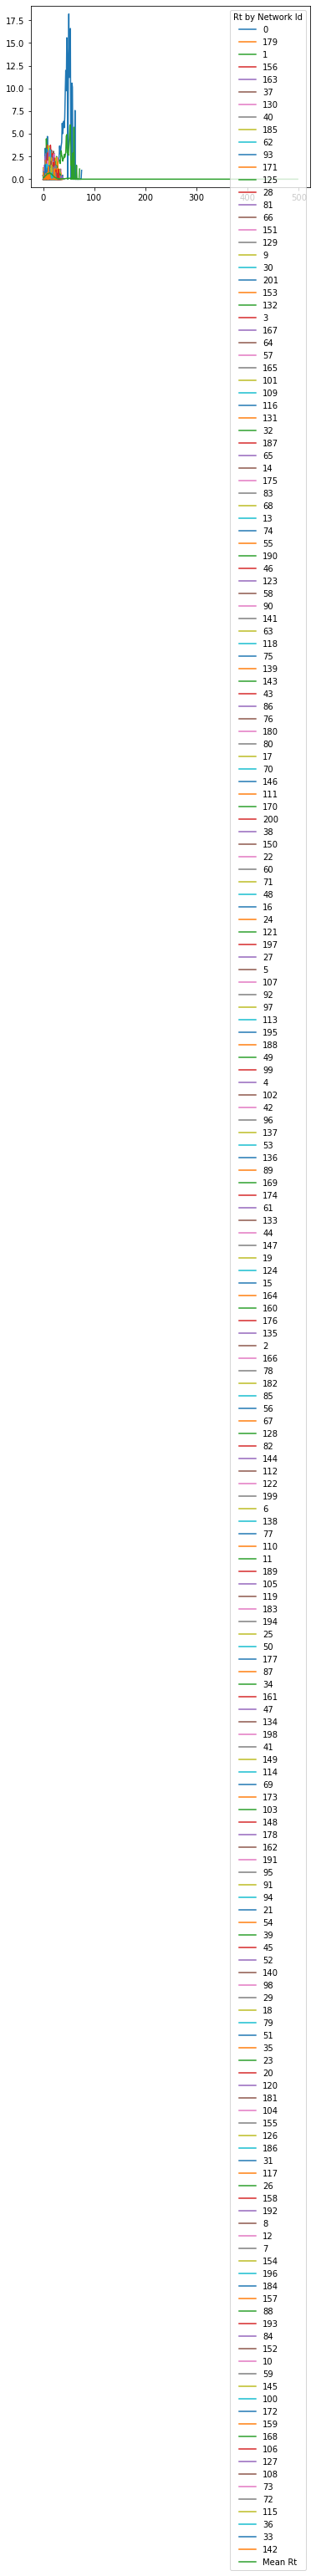

In [21]:
import matplotlib.pyplot as plt

networkDayDmp = analyserFinal.getRtDmpByNetwork()
mean = []
for a in range(1,500):
    mean.append(0.0)
for networkIdStr in networkDayDmp:
    plt.plot(networkDayDmp[networkIdStr],label=networkIdStr)
    for a in range(0,len(networkDayDmp[networkIdStr])):
        mean[a] += networkDayDmp[networkIdStr][a]
networkCount = len(networkDayDmp)

for a in range(0,499):
    mean[a] = mean[a] / networkCount

plt.plot(mean,label="Mean Rt")
plt.legend(title='Rt by Network Id')
plt.show()



rtDmp ORIGINAL length: 500
rtDmp length: 499
mean rtDmp length: 499
r0PerDay length: 499
r0FixedPerDay length: 499
rInstPerDay length: 499


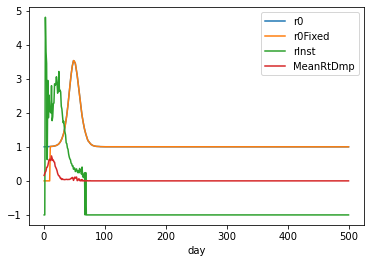

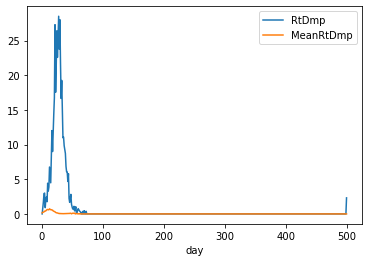

In [22]:

meanDmpPerDay = analyserFinal.getRtDmpPerDay()
print("rtDmp ORIGINAL length: " + str(len(meanDmpPerDay)))

meanDmpPerDay = meanDmpPerDay[-499:]

r0PerDay = analyserFinal.getR0PerDay()
r0FixedPerDay = analyserFinal.getR0FixedPerDay()
rInstPerDay = analyserFinal.getRInstPerDay()
# meanDmpPerDay = analyserFinal.getMeanDmpPerDay()
print("rtDmp length: " + str(len(meanDmpPerDay)))
print("mean rtDmp length: " + str(len(mean)))
print("r0PerDay length: " + str(len(r0PerDay)))
print("r0FixedPerDay length: " + str(len(r0FixedPerDay)))
print("rInstPerDay length: " + str(len(rInstPerDay)))
# print("meanDmpPerDay length: " + str(len(meanDmpPerDay))) # TODO debug why this is empty now

r0MultiStartWeight = pd.DataFrame({'day': range(1,500), 'r0': r0PerDay, 
                           'r0Fixed': r0FixedPerDay, 'rInst': rInstPerDay, 'MeanRtDmp': mean})
                                   #, 'RtDmp': meanDmpPerDay}) 
    # , 'g': gPerDay, 'gTen': gTenPerDay, 'gFive': gFivePerDay, 'gCont': gContPerDay, 'tau': tauPerDay})
r0MultiStartWeight.plot('day')

rtDmp = pd.DataFrame({'day': range(1,500), 'RtDmp': meanDmpPerDay, 'MeanRtDmp': mean})
rtDmp.plot('day')

In [23]:


# Other validity checking information:-

meanRtDmp = analyserFinal.getRtDmpOverallMean()
print("Mean RT using d(m,p) method:",meanRtDmp)


Mean RT using d(m,p) method: 7.540436147652245


In [24]:
meanOfNetworkMeanDmp = 0.0
countOfMeans = len(mean)
countOfMeansNonZero = 0
for a in range(1,countOfMeans):
    if mean[a] > 0:
        meanOfNetworkMeanDmp += mean[a]
        countOfMeansNonZero += 1
meanOfNetworkMeanDmp = meanOfNetworkMeanDmp / countOfMeansNonZero
print("Mean of network RT using d(m,p) method:",meanOfNetworkMeanDmp)

Mean of network RT using d(m,p) method: 0.20340645754378495


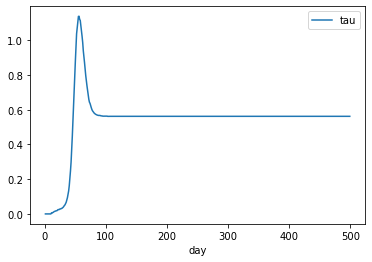

In [25]:


tauPerDay = analyserFinal.getTauPerDay()
tauPerDayBaseline = pd.DataFrame({'day': range(1,500), 'tau': tauPerDay})
tauPerDayBaseline.plot('day')



## Summary
Below are the above simulations shown on the same chart

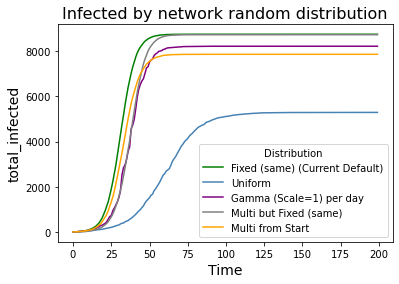

In [27]:
import matplotlib.pyplot as plt

plt.plot(timeseriesBaseline["total_infected"], label='Fixed (same) (Current Default)', color='green')
plt.plot(timeseriesUniform["total_infected"], label='Uniform', color='steelblue')
plt.plot(timeseriesGamma["total_infected"], label='Gamma (Scale=1) per day', color='purple')
plt.plot(timeseriesMulti["total_infected"], label='Multi but Fixed (same)', color='grey')
plt.plot(timeseriesMultiStart["total_infected"], label='Multi from Start', color='orange')
# plt.plot(timeseriesMultiStartWeight["total_infected"], label='Multi Weighted', color='red')

#add legend
plt.legend(title='Distribution')

#add axes labels and a title
plt.ylabel('total_infected', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Infected by network random distribution', fontsize=16)

plt.show()

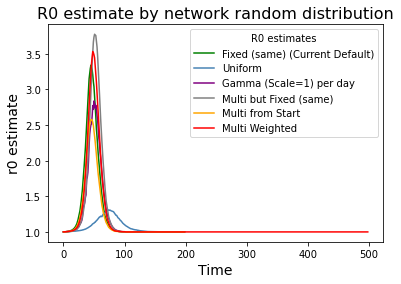

In [28]:
import matplotlib.pyplot as finalplt

finalplt.plot(r0Baseline["r0"], label='Fixed (same) (Current Default)', color='green')
finalplt.plot(r0Uniform["r0"], label='Uniform', color='steelblue')
finalplt.plot(r0Gamma["r0"], label='Gamma (Scale=1) per day', color='purple')
finalplt.plot(r0Multi["r0"], label='Multi but Fixed (same)', color='grey')
finalplt.plot(r0MultiStart["r0"], label='Multi from Start', color='orange')
finalplt.plot(r0MultiStartWeight["r0"], label='Multi Weighted', color='red')

#add legend
finalplt.legend(title='R0 estimates')

#add axes labels and a title
finalplt.ylabel('r0 estimate', fontsize=14)
finalplt.xlabel('Time', fontsize=14)
finalplt.title('R0 estimate by network random distribution', fontsize=16)

finalplt.show()

### What have we shown?
We have seen that introducing a greater degree of variability in the transmission multiplier within networks both on a per-day/per-type and per-type/entire-sim basis Can drastically alter the simulation outcome (See Uniform result).

We have also shown that varying occupation networks to select a value from a Gamma(1,1) distribution adds greater variability per network instance whilst maintaining a similar simulation output. (Gamma distribution per-day/per-type and per-type/entire-sim).

Finally we showed that weighting to a desired mean for just occupational networks with a large number of networks (200) instead of the default (5) produces similar population level simulation results whilst allowing for variability in types of occupational networks.

We have also shown that the Anderson and May estimate of R0 whereby R0 is proportional to the susceptible population (rather than both susceptible and infectives) remains true. The maximum r0 estimate for the original simulation and the final Multi Weighted (Gamma) simulation are comparable, as are the mean and variance of the r0 estimates per day of each simulation.

These results should allow us to proceed to tune simulations to reflect the real life types and variability of occupational networks, producing more accurate simulations at a more local level than is done today.

By adding in this level of programmability into the simulation's inputs we can move toward bridging the gap between per-person social mixing scoring or contact tracing via mobile devices and simulating based on these known mixing scores from the field.

Further work is required to define a reliable Social Mixing Score mechanism on mobile devices that is comparable between greatly variable mobile phones (i.e. phones with much higher transmission power and those with lower power), and using this mixing input by place (and thus network type and duration) to inform inputs to the OpenABM-Covid19 simulation.

### Future modifications
We need to do the same for the other network types, but currently there is no helper method for random or home networks as there is for occupation networks.

## Next Steps
Next I shall add a parameter for each network called distribution with the following options:-
- Fixed (as the original baseline)
- Uniform per network simulation step
- Uniform per network simulation
- Gamma per network simulation step (shape=1)
- Gamma per network simulation (shape=1)
- Weighted Gamma per network simulation step (shape=1)
- Weighted Gamma per network simulation (shape=1)

This will allow us to reproduce the above simulations via a simple parameters file rather than in Jupyter notebook. This will require modification to the OpenABM-Covid19 C code base.